#### **IMPORTING NECESSARY DEPENDENCIES**

In [ ]:
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
from pathlib import Path
import tensorflow as tf
from random import randint
from tensorflow import keras
#import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from keras.utils.vis_utils import plot_model
from tensorflow.keras import Sequential, Input
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from distutils.dir_util import copy_tree, remove_tree
from sklearn.metrics import balanced_accuracy_score as BAS
from tensorflow.keras.applications.resnet50 import ResNet50 
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.densenet import DenseNet169
from tensorflow.keras.applications.inception_v3 import InceptionV3
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.efficientnet import EfficientNetB3
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from keras_unet.models import vanilla_unet
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, MaxPool2D, GlobalAveragePooling2D

#### **Setting the seed for reproducibility**

In [ ]:
tf.random.set_seed(5638)
random.seed(5638)

#### **Defining Variables**

In [ ]:
EPOCHS = 20
BATCH_SIZE = 32
IMG_SIZE = 128
IMAGE_SIZE = [128, 128]
DIM = (IMG_SIZE, IMG_SIZE)

In [ ]:
train_dir = Path('C:/Users/DElL/Desktop/Project/Combined Dataset/train')

# Get filepaths and labels
filepaths = list(train_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
train_df = pd.concat([filepaths, labels], axis=1)

# Shuffle the DataFrame and reset index
train_df = train_df.sample(frac=1).reset_index(drop = True)

# Show the result
train_df.head(3)

In [ ]:
test_dir = Path('C:/Users/DElL/Desktop/Project/Combined Dataset/train')

# Get filepaths and labels
filepaths = list(test_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
test_df = pd.concat([filepaths, labels], axis=1)

# Shuffle the DataFrame and reset index
test_df = test_df.sample(frac=1).reset_index(drop = True)

# Show the result
test_df.head(3)

In [ ]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1.0/255.0)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1.0/255.0)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(128,128),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    seed = 5638,
    shuffle=False
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(128, 128),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    seed = 5638,
    shuffle=False
)

CLASSES = list(test_images.class_indices.keys())

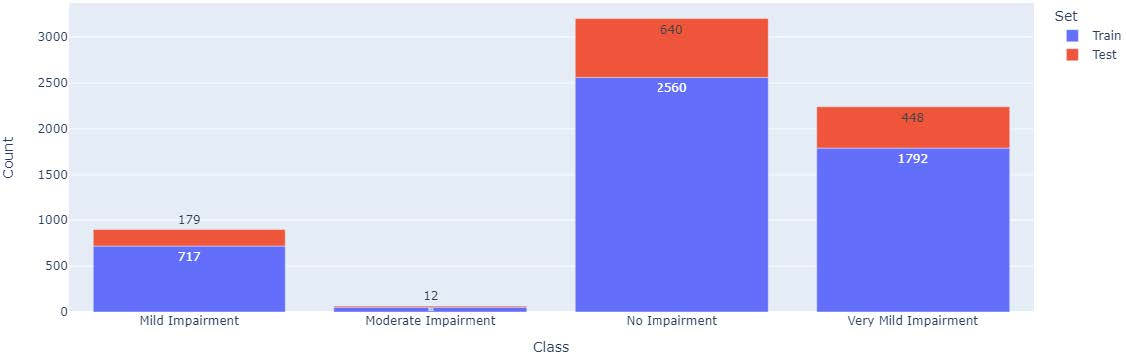

In [ ]:
# Display 25 picture of the dataset with their labels
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath[i]), cmap = 'gray')
    ax.set_title(test_df.Label[i])
plt.tight_layout()
plt.show()

In [ ]:
# Create the U-Net model
model = vanilla_unet()

In [ ]:
custom_model = Sequential([
    model,
    #Input(shape=(*IMAGE_SIZE, 3)),
    Conv2D(16, 3, activation='relu', padding='same'),
    Conv2D(16, 3, activation='relu', padding='same'),
    MaxPool2D(),
    Conv2D(32, 3, activation='relu', padding='same'),
    Conv2D(32, 3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPool2D(),
    Conv2D(64, 3, activation='relu', padding='same'),
    Conv2D(64, 3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPool2D(),
    #Conv2D(128, 3, activation='relu', padding='same'),
    #Conv2D(128, 3, activation='relu', padding='same'),
    #BatchNormalization(),
    #MaxPool2D(),
    #Conv2D(256, 3, activation='relu', padding='same'),
    #Conv2D(256, 3, activation='relu', padding='same'),
    #BatchNormalization(),
    # MaxPool2D(),
    # Conv2D(512, 3, activation='relu', padding='same'),
    # Conv2D(512, 3, activation='relu', padding='same'),
    # BatchNormalization(),
    # MaxPool2D(),
    # Conv2D(1024, 3, activation='relu', padding='same'),
    # Conv2D(1024, 3, activation='relu', padding='same', name = 'last_conv_layer'),
    # BatchNormalization(),
    # MaxPool2D(),
    Flatten(),
    Dropout(0.2),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.7),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(4, activation='softmax')        
], name = "cnn_model")

custom_model.summary()



In [ ]:
OPT = tf.keras.optimizers.Adam(learning_rate=0.001)
METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'), tf.keras.metrics.AUC(name='auc')]
custom_model.compile(optimizer='adam',loss=tf.losses.CategoricalCrossentropy(),metrics=METRICS)
earlystopping = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 10, verbose = 1)
filepath = './best_weights.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor = 'val_loss', mode='min', save_best_only=True, verbose = 1)
callback_list = [earlystopping, checkpoint]
#Fit the training data to the model and validate it using the validation data
custom_model_history = custom_model.fit(train_images,validation_data=test_images, callbacks=callback_list, epochs=EPOCHS)

In [ ]:
test_scores = custom_model.evaluate(test_images)
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))
pred_labels = custom_model.predict(test_images)

def roundoff(arr):
    """To round off according to the argmax of each predicted label array."""
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)
    
pred = np.argmax(pred_labels,axis=1)

print(classification_report(test_images.classes,pred,target_names=CLASSES))

In [ ]:
# Plot the confusion matrix

test_ls, pred_ls = test_images.classes,pred
conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels=CLASSES, yticklabels=CLASSES)

plt.title('Alzheimer\'s Disease Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

In [ ]:
#Other classification metrics
print("Balanced Accuracy Score: {} %".format(round(BAS(test_ls, pred_ls) * 100, 2)))
print("Matthew's Correlation Coefficient: {} %".format(round(MCC(test_ls, pred_ls) * 100, 2)))

In [ ]:
custom_model.save('custom_cnn_(94.56%).h5')